In [ ]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

Изменим сеть LeNet, для повышения качества на валидации. Функции активации tanh() уже не используют, так как они приводят к затуханию градиента. Свертку 5 на 5 тоже не используют, используют две свертки 3 на 3 (весов меньше, следовательно, меньше вероятность переобучения). AvdPool тоже не используют. Нужно заменить на MaxPool.

Мы использовали датасет MNIST, но на нем сети всегда хорошо обучаются. Возьмем датасет посложнее -  CIFAR-10, 10 классов, а есть CIFAR-100, 100 классов.

In [ ]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic=True

In [ ]:
#скачивание датасета для классификации изображений
import torchvision.datasets

CIFAR_train = torchvision.datasets.CIFAR10('./', download = True, train = True)
CIFAR_test = torchvision.datasets.CIFAR10('./', download = True, train = False)

In [ ]:
X_train = torch.FloatTensor(CIFAR_train.data)
y_train = torch.LongTensor(CIFAR_train.targets)
X_test = torch.FloatTensor(CIFAR_test.data)
y_test = torch.LongTensor(CIFAR_test.targets)

In [ ]:
X_train.min(),X_train.max()

(tensor(0.), tensor(255.))

Каждый цвет кодируется от 0 до 255 в виде float. Чтобы отобразить, нужны либо int 0-255, либо float 0-1. У нас тензоры float.

In [ ]:
X_train/= 255
X_test/= 255

In [ ]:
CIFAR_train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

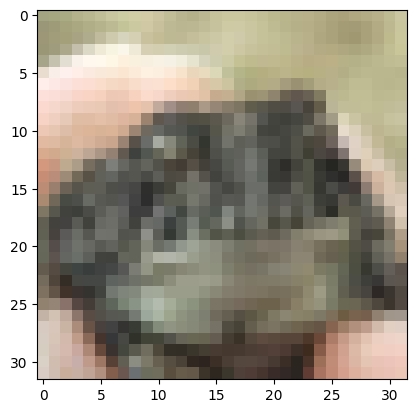

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X_train[25])

In [ ]:
X_train.shape

torch.Size([50000, 32, 32, 3])

Не та размерность.

Надо (кол-во изображений, кол-во каналов, высота, ширина). Каналы должны быть на 2 месте. Здесь на 4.

In [ ]:
# с помощью метода permute изменить размерность тензора
X_train = X_train.permute(0, 3, 1, 2)
X_test =  X_test.permute(0, 3, 1, 2)

In [ ]:
X_train.shape

torch.Size([50000, 3, 32, 32])

In [ ]:
torch.cuda.empty_cache()

In [ ]:
import torch.nn.functional as func
import torch.optim as optim

class LeNet(torch.nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()
    self.conv1 = torch.nn.Conv2d(3, 6, kernel_size=5)
    self.conv2 = torch.nn.Conv2d(6, 16, kernel_size=5)
    self.fc1 = torch.nn.Linear(16*5*5, 120)
    self.fc2 = torch.nn.Linear(120, 84)
    self.fc3 = torch.nn.Linear(84, 10)
    self.sm = torch.nn.Softmax(dim=1)
    self.tan = torch.nn.Tanh()

  def forward(self, x):
      x = self.conv1(x)
      x = self.tan(x)
      x = func.avg_pool2d(x, 2)
      x = self.conv2(x)
      x = self.tan(x)
      x = func.avg_pool2d(x, 2)
      x = x.view(x.size(0), x.size(1)* x.size(2) * x.size(3))
      x = self.fc1(x)
      x = self.fc2(x)
      x = self.fc3(x)
      return x

  def predict(self, x):
    x=self.forward(x)
    x=x.to(device)
    x=self.sm(x)
    return x

net = LeNet()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = net.to(device)
loss = torch.nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
from tqdm.auto import tqdm
batch_size = 100
X_test = X_test.to(device)
y_test = y_test.to(device)

X_train = X_train.to(device)
y_train = y_train.to(device)
arr_train = []
for epoch in tqdm(range(40)):
  all_loss, k = 0, 0
  order = np.random.permutation(len(X_train))
  for start_index in range (0, len(X_train), batch_size):
    opt.zero_grad() 
    batch_index = order[start_index:start_index+batch_size]
    X_batch = X_train[batch_index]
    y_batch = y_train[batch_index]
    preds = net.forward(X_batch)
    loss_val = loss(preds, y_batch)
    loss_val.backward()
    opt.step()
    all_loss += loss_val.item()
    k += 1
  arr_train.append(all_loss/k)

  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score

with torch.no_grad():
   test_model_pred = torch.argmax(net.predict(X_test), dim=1)
   df_accuracy = pd.DataFrame({"Net": "LeNet", "Accuracy": accuracy_score(y_test.cpu(), test_model_pred.cpu())}, index=[0])

NameError: ignored

In [ ]:
import torch.nn.functional as func
import torch.optim as optim

class LeNetRelu(torch.nn.Module):
  def __init__(self):
    super(LeNetRelu, self).__init__()
    self.conv1 = torch.nn.Conv2d(3, 6, kernel_size=5)
    self.conv2 = torch.nn.Conv2d(6, 16, kernel_size=5)
    self.fc1 = torch.nn.Linear(16*5*5, 120)
    self.fc2 = torch.nn.Linear(120, 84)
    self.fc3 = torch.nn.Linear(84, 10)
    self.sm = torch.nn.Softmax(dim=1)
    self.tan = torch.nn.Tanh()
    self.relu = torch.nn.ReLU()

  def forward(self, x):
      x = self.conv1(x)
      x = self.relu(x)
      x = func.avg_pool2d(x, 2)
      x = self.conv2(x)
      x = self.relu(x)
      x = func.avg_pool2d(x, 2)
      x = x.view(x.size(0), x.size(1)* x.size(2) * x.size(3))
      x = self.fc1(x)
      x = self.fc2(x)
      x = self.fc3(x)
      return x

  def predict(self, x):
    x=self.forward(x)
    x=x.to(device)
    x=self.sm(x)
    return x

netRelu = LeNetRelu()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
netRelu = netRelu.to(device)
loss = torch.nn.CrossEntropyLoss()
opt = optim.Adam(netRelu.parameters(), lr=0.001)

In [ ]:
batch_size = 100
X_test = X_test.to(device)
y_test = y_test.to(device)

X_train = X_train.to(device)
y_train = y_train.to(device)
arr_train_relu = []
for epoch in tqdm(range(40)):
  all_loss, k = 0, 0
  order = np.random.permutation(len(X_train))
  for start_index in range (0, len(X_train), batch_size):
    opt.zero_grad() 
    batch_index = order[start_index:start_index+batch_size]
    X_batch = X_train[batch_index]
    y_batch = y_train[batch_index]
    preds = netRelu.forward(X_batch)
    loss_val = loss(preds, y_batch)
    loss_val.backward()
    opt.step()
    all_loss += loss_val.item()
    k += 1
  arr_train_relu.append(all_loss/k)

  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
with torch.no_grad():
   test_model_pred = torch.argmax(netRelu.predict(X_test), dim=1)
   df_accuracy1 = pd.DataFrame({"Net": "LeNetRELU", "Accuracy": accuracy_score(y_test.cpu(), test_model_pred.cpu())}, index=[0])
   df_accuracy = pd.concat([df_accuracy, df_accuracy1])

In [ ]:
import torch.nn.functional as func
import torch.optim as optim

class LeNetMaxPool(torch.nn.Module):
  def __init__(self):
    super(LeNetMaxPool, self).__init__()
    self.conv1 = torch.nn.Conv2d(3, 6, kernel_size=5)
    self.conv2 = torch.nn.Conv2d(6, 16, kernel_size=5)
    self.fc1 = torch.nn.Linear(16*5*5, 120)
    self.fc2 = torch.nn.Linear(120, 84)
    self.fc3 = torch.nn.Linear(84, 10)
    self.sm = torch.nn.Softmax(dim=1)
    self.relu = torch.nn.ReLU()

  def forward(self, x):
      x = self.conv1(x)
      x = self.relu(x)
      x = func.max_pool2d(x, 2)
      x = self.conv2(x)
      x = self.relu(x)
      x = func.max_pool2d(x, 2)
      x = x.view(x.size(0), x.size(1)* x.size(2) * x.size(3))
      x = self.fc1(x)
      x = self.fc2(x)
      x = self.fc3(x)
      return x

  def predict(self, x):
    x=self.forward(x)
    x=x.to(device)
    x=self.sm(x)
    return x

netMaxPool = LeNetMaxPool()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
netMaxPool = netMaxPool.to(device)
opt = optim.Adam(netMaxPool.parameters(), lr=0.001)

In [ ]:
batch_size = 100
X_test = X_test.to(device)
y_test = y_test.to(device)

X_train = X_train.to(device)
y_train = y_train.to(device)
arr_train_pool = []
for epoch in tqdm(range(40)):
  all_loss, k = 0, 0
  order = np.random.permutation(len(X_train))
  for start_index in range (0, len(X_train), batch_size):
    opt.zero_grad() 
    batch_index = order[start_index:start_index+batch_size]
    X_batch = X_train[batch_index]
    y_batch = y_train[batch_index]
    preds = netMaxPool.forward(X_batch)
    loss_val = loss(preds, y_batch)
    loss_val.backward()
    opt.step()
    all_loss += loss_val.item()
    k += 1
  arr_train_pool.append(all_loss/k)

  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
with torch.no_grad():
   test_model_pred = torch.argmax(netMaxPool.predict(X_test), dim=1)
   df_accuracy1 = pd.DataFrame({"Net": "LeNetMaxPool", "Accuracy": accuracy_score(y_test.cpu(), test_model_pred.cpu())}, index=[0])
   df_accuracy = pd.concat([df_accuracy, df_accuracy1])

In [ ]:
import torch.nn.functional as func
import torch.optim as optim

class LeNet2(torch.nn.Module):
  def __init__(self):
    super(LeNet2, self).__init__()
    self.conv1 = torch.nn.Conv2d(3, 6, kernel_size=3)
    self.conv2 = torch.nn.Conv2d(6, 6, kernel_size=3)
    self.fc1 = torch.nn.Linear(16*5*5, 120)
    self.fc2 = torch.nn.Linear(120, 84)
    self.fc3 = torch.nn.Linear(84, 10)
    self.sm = torch.nn.Softmax(dim=1)
    self.relu = torch.nn.ReLU()
    self.conv3 = torch.nn.Conv2d(6, 16, kernel_size=3)
    self.conv4 = torch.nn.Conv2d(16, 16, kernel_size=3)

  def forward(self, x):
      x = self.conv1(x)
      x = self.conv2(x)
      x = self.relu(x)
      x = func.max_pool2d(x, 2)
      x = self.conv3(x)
      x = self.conv4(x)
      x = self.relu(x)
      x = func.max_pool2d(x, 2)
      x = x.view(x.size(0), x.size(1)* x.size(2) * x.size(3))
      x = self.fc1(x)
      x = self.fc2(x)
      x = self.fc3(x)
      return x

  def predict(self, x):
    x=self.forward(x)
    x=x.to(device)
    x=self.sm(x)
    return x

net2 = LeNet2()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net2 = net2.to(device)
opt = optim.Adam(net2.parameters(), lr=0.001)

In [ ]:
batch_size = 100
X_test = X_test.to(device)
y_test = y_test.to(device)

X_train = X_train.to(device)
y_train = y_train.to(device)
arr_train_2 = []
for epoch in tqdm(range(40)):
  all_loss, k = 0, 0
  order = np.random.permutation(len(X_train))
  for start_index in range (0, len(X_train), batch_size):
    opt.zero_grad() 
    batch_index = order[start_index:start_index+batch_size]
    X_batch = X_train[batch_index]
    y_batch = y_train[batch_index]
    preds = net2.forward(X_batch)
    loss_val = loss(preds, y_batch)
    loss_val.backward()
    opt.step()
    all_loss += loss_val.item()
    k += 1
  arr_train_2.append(all_loss/k)

  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
with torch.no_grad():
   test_model_pred = torch.argmax(net2.predict(X_test), dim=1)
   df_accuracy1 = pd.DataFrame({"Net": "LeNet2", "Accuracy": accuracy_score(y_test.cpu(), test_model_pred.cpu())}, index=[0])
   df_accuracy = pd.concat([df_accuracy, df_accuracy1])

In [ ]:
df_accuracy

,Net,Accuracy
0,LeNet,0.5593
0,LeNetRELU,0.6208
0,LeNetMaxPool,0.6176
0,LeNet2,0.6503


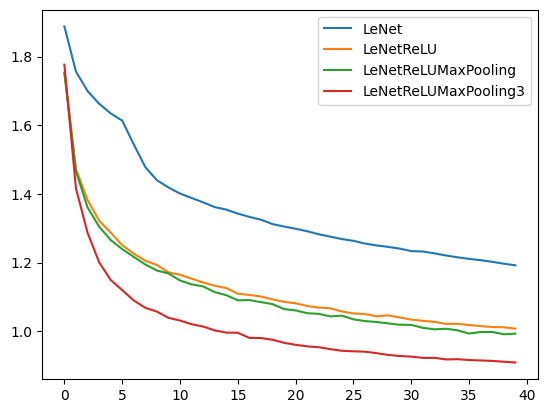

In [ ]:
# for i in range(len(arr_train)):
#   arr_train[i] = arr_train[i].cpu().detach().numpy()
#   arr_train_relu[i] = arr_train_relu[i].cpu().detach().numpy()
#   arr_train_pool[i] = arr_train_pool[i].cpu().detach().numpy()
#   arr_train_2[i] = arr_train_2[i].cpu().detach().numpy()
epoch_s = [i for i in range(40)]
plt.plot(epoch_s, arr_train, label="LeNet")
plt.plot(epoch_s, arr_train_relu, label="LeNetReLU")
plt.plot(epoch_s, arr_train_pool, label="LeNetReLUMaxPooling")
plt.plot(epoch_s, arr_train_2, label="LeNetReLUMaxPooling3")
plt.legend()
plt.show()

In [ ]:
import torch.nn.functional as func
import torch.optim as optim

class LeNetBatchNorm(torch.nn.Module):
  def __init__(self):
    super(LeNetBatchNorm, self).__init__()
    self.conv1 = torch.nn.Conv2d(3, 6, kernel_size=3)
    self.conv2 = torch.nn.Conv2d(6, 6, kernel_size=3)
    self.fc1 = torch.nn.Linear(16*5*5, 120)
    self.bn1 = torch.nn.BatchNorm2d(6)
    self.fc2 = torch.nn.Linear(120, 84)
    self.bn2 = torch.nn.BatchNorm2d(16)
    self.fc3 = torch.nn.Linear(84, 10)
    self.sm = torch.nn.Softmax(dim=1)
    self.relu = torch.nn.ReLU()
    self.conv3 = torch.nn.Conv2d(6, 16, kernel_size=3)
    self.conv4 = torch.nn.Conv2d(16, 16, kernel_size=3)

  def forward(self, x):
      x = self.conv1(x)
      x = self.conv2(x)
      x = self.bn1(x)
      x = self.relu(x)
      x = func.max_pool2d(x, 2)
      x = self.conv3(x)
      x = self.conv4(x)
      x = self.bn2(x)
      x = self.relu(x)
      x = func.max_pool2d(x, 2)
      x = x.view(x.size(0), x.size(1)* x.size(2) * x.size(3))
      x = self.fc1(x)
      x = self.fc2(x)
      x = self.fc3(x)
      return x

  def predict(self, x):
    x=self.forward(x)
    x=x.to(device)
    x=self.sm(x)
    return x

netBatch = LeNetBatchNorm()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
netBatch = netBatch.to(device)
opt = optim.Adam(netBatch.parameters(), lr=0.001)

In [ ]:
netBatch.train()

batch_size = 100
X_test = X_test.to(device)
y_test = y_test.to(device)

X_train = X_train.to(device)
y_train = y_train.to(device)
arr_train_batch = []
for epoch in tqdm(range(40)):
  all_loss, k = 0, 0
  order = np.random.permutation(len(X_train))
  for start_index in range (0, len(X_train), batch_size):
    opt.zero_grad() 
    batch_index = order[start_index:start_index+batch_size]
    X_batch = X_train[batch_index]
    y_batch = y_train[batch_index]
    preds = netBatch.forward(X_batch)
    loss_val = loss(preds, y_batch)
    loss_val.backward()
    opt.step()
    all_loss += loss_val.item()
    k += 1
  arr_train_batch.append(all_loss/k)

  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
netBatch.eval() 

with torch.no_grad():
   test_model_pred = torch.argmax(netBatch.predict(X_test), dim=1)
   df_accuracy1 = pd.DataFrame({"Net":"LeNetBatchNorm", "Accuracy":accuracy_score(y_test.cpu(), test_model_pred.cpu())}, index=[0])
   df_accuracy = pd.concat([df_accuracy, df_accuracy1])

In [ ]:
df_accuracy

,Net,Accuracy
0,LeNet,0.5593
0,LeNetRELU,0.6208
0,LeNetMaxPool,0.6176
0,LeNet2,0.6503
0,LeNetBatchNorm,0.6498


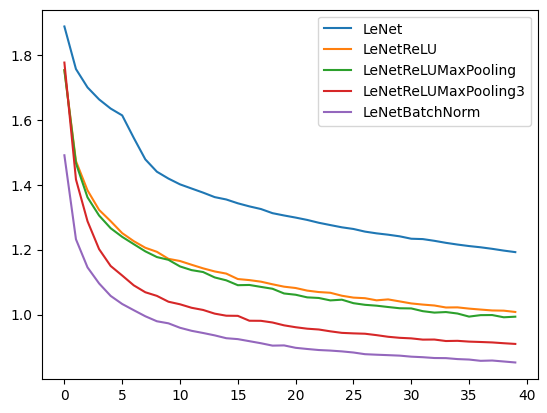

In [ ]:
# for i in range(len(arr_train)):
#   arr_train_batch[i] = arr_train_batch[i].cpu().detach().numpy()
epoch_s = [i for i in range(40)]
plt.plot(epoch_s, arr_train, label="LeNet")
plt.plot(epoch_s, arr_train_relu, label="LeNetReLU")
plt.plot(epoch_s, arr_train_pool, label="LeNetReLUMaxPooling")
plt.plot(epoch_s, arr_train_2, label="LeNetReLUMaxPooling3")
plt.plot(epoch_s, arr_train_batch, label="LeNetBatchNorm")
plt.legend()

# 4 практика

In [ ]:
from torchvision.models import alexnet, vgg16, resnet50, googlenet
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)
torch.cuda.manual_seed(123)
torch.backends.cudnn.deterministic=True

In [ ]:
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from torchvision import datasets, models, transforms
Transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485,0.456,0.406], std = [0.229,0.224,0.225])])

CIFAR_train = datasets.CIFAR10(root='./data/train', train=True, download=True, transform=Transform)
CIFAR_test = datasets.CIFAR10(root='./data/test', train=False, download=True, transform=Transform)

100%|██████████| 170498071/170498071 [00:03<00:00, 47676476.93it/s]


Extracting ./data/train/cifar-10-python.tar.gz to ./data/train


100%|██████████| 170498071/170498071 [00:03<00:00, 49103409.23it/s]


Extracting ./data/test/cifar-10-python.tar.gz to ./data/test


## AlexNet

In [ ]:
train_loader = DataLoader(CIFAR_train, batch_size=1000, shuffle=True)
test_loader = DataLoader(CIFAR_test, batch_size=1000)

In [ ]:
modelAlex = alexnet(pretrained=True) 

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 233MB/s]


In [ ]:
for param in modelAlex.parameters():
    param.requires_grad = False

In [ ]:
modelAlex.classifier[6] = torch.nn.Linear(4096, 10)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
modelAlex=modelAlex.to(device)

In [ ]:
modelAlex.eval()
with torch.no_grad():
    test_data, test_target = next(iter(test_loader))
    test_data = test_data.to(device)
    test_model_pred = torch.argmax(modelAlex(test_data), dim=1)
    print('Точность (accuracy) на тестовой выборке без дообучения:', accuracy_score(test_target.cpu(), test_model_pred.cpu()))

Точность (accuracy) на тестовой выборке без дообучения: 0.11


In [ ]:
opt = torch.optim.Adam(modelAlex.classifier[6].parameters(), lr=0.001)
loss = torch.nn.CrossEntropyLoss()

In [ ]:
from tqdm.auto import tqdm
modelAlex.train()
loss_history = []
for epoch in tqdm(range(10)):
    for i, (batch, labels) in enumerate(train_loader):
        batch = batch.to(device)
        opt.zero_grad()
        loss_val = loss(modelAlex(batch), labels.to(device))
        loss_val.backward()
        opt.step()
        loss_history.append(loss_val.log().item())

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
modelAlex.eval()
with torch.no_grad():
    test_data, test_target = next(iter(test_loader))
    test_data = test_data.to(device)
    test_model_pred = torch.argmax(modelAlex(test_data), dim=1)
    print('Точность (accuracy) на тестовой выборке после дообучения:', accuracy_score(test_target.cpu(), test_model_pred.cpu()))

Точность (accuracy) на тестовой выборке после дообучения: 0.845


## VGG

In [ ]:
train_loader = DataLoader(CIFAR_train, batch_size=100, shuffle=True)
test_loader = DataLoader(CIFAR_test, batch_size=100)

In [ ]:
modelVGG = vgg16(pretrained=True)
for param in modelVGG.parameters(): 
    param.requires_grad = False
modelVGG.classifier[6] = torch.nn.Linear(4096, 10)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
modelVGG=modelVGG.to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 232MB/s]


In [ ]:
modelVGG.eval()
with torch.no_grad():
    test_data, test_target = next(iter(test_loader))
    test_data = test_data.to(device)
    test_model_pred = torch.argmax(modelVGG(test_data), dim=1)
    print('Точность на тестовой выборке без дообучения:', accuracy_score(test_target.cpu(), test_model_pred.cpu()))

Точность на тестовой выборке без дообучения: 0.11


In [ ]:
opt = torch.optim.Adam(modelVGG.classifier[6].parameters(), lr=0.001)
loss = torch.nn.CrossEntropyLoss()

In [ ]:
from tqdm.auto import tqdm
modelVGG.train()
loss_history = []
for epoch in tqdm(range(10)):
    for i, (batch, labels) in enumerate(train_loader):
        batch = batch.to(device)
        opt.zero_grad()
        loss_val = loss(modelVGG(batch), labels.to(device))
        loss_val.backward()
        opt.step()
        loss_history.append(loss_val.log().item())

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
modelVGG.eval()
with torch.no_grad():
    test_data, test_target = next(iter(test_loader))
    test_data = test_data.to(device)
    test_model_pred = torch.argmax(modelVGG(test_data), dim=1)
    print('Точность (accuracy) на тестовой выборке после дообучения:', accuracy_score(test_target.cpu(), test_model_pred.cpu()))

Точность (accuracy) на тестовой выборке после дообучения: 0.88


## ResNet

In [ ]:
train_loader = DataLoader(CIFAR_train, batch_size=100, shuffle=True)
test_loader = DataLoader(CIFAR_test, batch_size=100)

In [ ]:
modelRES = resnet50(pretrained=True)
for param in modelRES.parameters(): 
    param.requires_grad = False
modelRES.fc = torch.nn.Sequential(torch.nn.Linear(in_features=2048, out_features=1000), 
                                  torch.nn.ReLU(inplace=True), 
                                  torch.nn.Linear(in_features=1000, out_features=10))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
modelRES=modelRES.to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
modelRES.eval()
with torch.no_grad():
    test_data, test_target = next(iter(test_loader))
    test_data = test_data.to(device)
    test_model_pred = torch.argmax(modelRES(test_data), dim=1)
    print('Точность на тестовой выборке без дообучения:', accuracy_score(test_target.cpu(), test_model_pred.cpu()))

Точность на тестовой выборке без дообучения: 0.08


In [ ]:
opt = torch.optim.Adam(modelRES.fc[2].parameters(), lr=0.001)
loss = torch.nn.CrossEntropyLoss()

In [ ]:
modelRES.train()
loss_history = []
for epoch in tqdm(range(10)):
    for i, (batch, labels) in enumerate(train_loader):
        batch = batch.to(device)
        opt.zero_grad()
        loss_val = loss(modelRES(batch), labels.to(device))
        loss_val.backward()
        opt.step()
        loss_history.append(loss_val.log().item())

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
modelRES.eval()
with torch.no_grad():
    test_data, test_target = next(iter(test_loader))
    test_data = test_data.to(device)
    test_model_pred = torch.argmax(modelRES(test_data), dim=1)
    print('Точность (accuracy) на тестовой выборке после дообучения:', accuracy_score(test_target.cpu(), test_model_pred.cpu()))

Точность (accuracy) на тестовой выборке после дообучения: 0.82


## GoogleNet

In [ ]:
train_loader = DataLoader(CIFAR_train, batch_size=500, shuffle=True)
test_loader = DataLoader(CIFAR_test, batch_size=500)

In [ ]:
modelGoogle = googlenet(pretrained=True)
for param in modelGoogle.parameters(): 
    param.requires_grad = False
modelGoogle.fc = torch.nn.Sequential(torch.nn.Linear(in_features=1024, out_features=500), 
                                  torch.nn.ReLU(inplace=True), 
                                  torch.nn.Linear(in_features=500, out_features=10))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
modelGoogle=modelGoogle.to(device)

In [ ]:
modelGoogle.eval()
with torch.no_grad():
    test_data, test_target = next(iter(test_loader))
    test_data = test_data.to(device)
    test_model_pred = torch.argmax(modelGoogle(test_data), dim=1)
    print('Точность на тестовой выборке без дообучения:', accuracy_score(test_target.cpu(), test_model_pred.cpu()))

Точность на тестовой выборке без дообучения: 0.128


In [ ]:
opt = torch.optim.Adam(modelGoogle.fc[2].parameters(), lr=0.001)
loss = torch.nn.CrossEntropyLoss()

In [ ]:
from tqdm.auto import tqdm
modelGoogle.train()
loss_history = []
for epoch in tqdm(range(10)):
    for i, (batch, labels) in enumerate(train_loader):
        batch = batch.to(device)
        opt.zero_grad()
        loss_val = loss(modelGoogle(batch), labels.to(device))
        loss_val.backward()
        opt.step()
        loss_history.append(loss_val.log().item())

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
modelGoogle.eval()
with torch.no_grad():
    test_data, test_target = next(iter(test_loader))
    test_data = test_data.to(device)
    test_model_pred = torch.argmax(modelGoogle(test_data), dim=1)
    print('Точность (accuracy) на тестовой выборке после дообучения:', accuracy_score(test_target.cpu(), test_model_pred.cpu()))

Точность (accuracy) на тестовой выборке после дообучения: 0.714
